<a href="https://colab.research.google.com/github/Elias-Schwegler/IAI_News_Analizer_Pub/blob/main/realtime_news_analyzer_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real-Time News Analyzer - In-Class Project

## Project Overview
Today you'll build a real-time news analysis system that:
1. **Scrapes** current headlines from a major news website
2. **Cleans** and processes the text data
3. **Analyzes** content using AI models (sentiment, entities, summaries)
4. **Visualizes** trends and patterns
5. **Presents** key insights to the class
ayouiwoso





## Step 0: Setup and Initialization

Run this cell first to load all necessary libraries and models. This might take a minute.

In [ ]:
# Install required packages (if needed)
!pip install -q requests beautifulsoup4 transformers torch pandas matplotlib seaborn spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 114.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Import all necessary libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# NLP imports
import spacy
from transformers import pipeline

# Load spaCy model
try:
    nlp = spacy.load('en_core_web_sm')
    print("✅ SpaCy loaded successfully")
except:
    print("⚠️ SpaCy model not found. Run: python -m spacy download en_core_web_sm")

# Initialize transformer pipelines (this may take a moment)

#sentiment analyzer
sentiment_analyzer = pipeline("sentiment-analysis",
                             model="distilbert-base-uncased-finetuned-sst-2-english")

#named entity recognition
ner_pipeline = pipeline("ner", grouped_entities=True,
                       model="dslim/bert-base-NER")


# Optional: Uncomment if you want to use these (they're larger models)
# summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
# classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")


✅ SpaCy loaded successfully


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


## Step 1: Choose Your News Website

Each team should pick ONE website from the list below. Once chosen, update the `YOUR_SITE` variable.

In [ ]:
# Available news websites (each team picks one)
NEWS_SITES = {
    "BBC Tech": "https://www.bbc.com/news/technology",
    "TechCrunch": "https://techcrunch.com/",
    "The Verge": "https://www.theverge.com/tech",
    "Reuters Tech": "https://www.reuters.com/technology/",
    "CNN Tech": "https://www.cnn.com/business/tech",
    "Wired": "https://www.wired.com/",
    "Ars Technica": "https://arstechnica.com/",
    "Hacker News": "https://news.ycombinator.com/",
    "MIT News": "https://news.mit.edu/",
    "Science Daily": "https://www.sciencedaily.com/news/computers_math/",
    "The Guardian Tech": "https://www.theguardian.com/uk/technology",
    "NPR Tech": "https://www.npr.org/sections/technology/"
}

# ⚡ CHANGE THIS TO YOUR CHOSEN WEBSITE ⚡
YOUR_SITE_NAME = "Wired"  # Change this!
YOUR_SITE_URL = NEWS_SITES['Wired']

print(f"🌐 Your team is analyzing: {YOUR_SITE_NAME}")
print(f"📍 URL: {YOUR_SITE_URL}")
print("\nTip: Open this URL in your browser to inspect the HTML structure!")

🌐 Your team is analyzing: Wired
📍 URL: https://www.wired.com/

Tip: Open this URL in your browser to inspect the HTML structure!


## Step 2: Scrape Headlines

Your task: Extract today's headlines from your chosen website.

### 💡 Scraping Tips:
1. Right-click on a headline in your browser → "Inspect" to see HTML structure
2. Look for patterns in class names or tag types
3. Start by getting just ONE headline working, then expand
4. Different sites use different structures - be flexible!

In [ ]:
def scrape_headlines(url):
    """
    TODO: Scrape headlines from your news site

    Returns: List of dictionaries with at least 'title' key
    Example: [{'title': 'AI Breakthrough...', 'link': 'http://...'}, ...]
    """

    # Headers to avoid being blocked
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
    }

    # Make the request
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    found_articles = []

    # For Wired, headlines are often within 'h2' or 'h3' tags,
    # sometimes inside an 'a' tag for the link.
    # Let's find all h2 and h3 tags and process them.
    headline_tags = soup.find_all(['h2', 'h3'])

    for tag in headline_tags:
        title = tag.get_text(strip=True)
        link = ""
        # Check if the headline is wrapped in an anchor tag to get the link
        parent_a = tag.find_parent('a')
        if parent_a and parent_a.get('href'):
            # Use requests.compat.urljoin to handle relative URLs correctly
            link = requests.compat.urljoin(url, parent_a.get('href'))

        if title: # Only add if a title was successfully extracted
            found_articles.append(title)

    return found_articles

found_articles = scrape_headlines(YOUR_SITE_URL)

#TEST
for i in range(len(found_articles)):
    print(f"{i}. {found_articles[i]}")

0. Today's Picks
1. Trending Stories
2. He Hunted Alleged Groomers on Roblox. Then the Company Banned Him
3. Sam Bankman-Fried Goes on the Offensive
4. Trump Is Boosting MAGA X Accounts Operating Overseas
5. Amazon Is Using Specialized AI Agents for Deep Bug Hunting
6. Wish List 2025: WIRED’s Gift Guide for the Creators, Dreamers, and Voyagers in Your Life
7. Kilian Jornet’s Mountain-Conquering Starter Pack
8. A $100 Billion Chip Project Forced a 91-Year-Old Woman From Her Home
9. Can Tech Get Rid of Bad Trips?
10. Reviews
11. The LG UltraFine 6K Monitor Put More Pixels on My Desk Than Ever
12. The Best Mushroom Coffee for an Alternative Buzz
13. Wish List 2025: WIRED’s Gift Guide for the Creators, Dreamers, and Voyagers in Your Life
14. Our 11 Favorite Down Comforters
15. Black Friday
16. Now’s the Best Time to Upgrade to a Herman Miller Office Chair
17. 10 Best Early Black Friday Tech Deals From Best Buy
18. The Best Early Black Friday Deals to Snag Before They Expire
19. The Best Re

### Troubleshooting Scraper

If your scraper isn't working, try this debugging approach:

In [ ]:
# DEBUG HELPER: Inspect the page structure
def inspect_page_structure(url):
    """Helper function to understand page structure"""
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    print("🔍 Page Structure Analysis:")
    print("-" * 40)

    # Find all h1, h2, h3 tags
    for tag in ['h1', 'h2', 'h3']:
        elements = soup.find_all(tag)
        if elements:
            print(f"\n{tag.upper()} tags found: {len(elements)}")
            # Show first element with its classes
            first = elements[0]
            classes = first.get('class', [])
            print(f"  First {tag} classes: {classes}")
            print(f"  Text: {first.get_text().strip()[:50]}...")

    # Look for common article containers
    print("\n🎯 Looking for article containers...")
    for selector in ['article', 'div.post', 'div.story', 'div.article']:
        elements = soup.select(selector)
        if elements:
            print(f"  Found {len(elements)} elements matching '{selector}'")

    return soup

# Uncomment to debug your site:
# soup = inspect_page_structure(YOUR_SITE_URL)

### 🆘 Emergency Backup: RSS Feed

If scraping is too difficult, use this RSS feed approach:

In [ ]:
# EMERGENCY BACKUP - Use RSS feeds if website scraping fails
def scrape_rss_feed(feed_url, source_name):
    """Backup method using RSS feeds"""
    import feedparser

    feed = feedparser.parse(feed_url)
    articles = []

    for entry in feed.entries[:20]:
        articles.append({
            'title': entry.title,
            'link': entry.link,
            'summary': entry.get('summary', '')[:200],
            'source': source_name
        })

    return articles

# RSS Feed URLs (backup option)
RSS_FEEDS = {
    "BBC Tech": "https://feeds.bbci.co.uk/news/technology/rss.xml",
    "TechCrunch": "https://techcrunch.com/feed/",
    "The Verge": "https://www.theverge.com/rss/index.xml",
    "Ars Technica": "https://feeds.arstechnica.com/arstechnica/index",
    "Wired": "https://www.wired.com/feed/rss"
}

# Uncomment to use RSS instead:
# if YOUR_SITE_NAME in RSS_FEEDS:
#     articles = scrape_rss_feed(RSS_FEEDS[YOUR_SITE_NAME], YOUR_SITE_NAME)
#     df_articles = pd.DataFrame(articles)
#     print(f"✅ Loaded {len(articles)} articles from RSS feed")

## Step 3: Clean and Process Text

Clean the scraped text data and prepare it for analysis.

In [ ]:
df=pd.DataFrame()
df["Headers_text_dirty"]=found_articles


In [ ]:
df

,Headers_text_dirty
0,Today's Picks
1,Trending Stories
2,He Hunted Alleged Groomers on Roblox. Then the...
3,Sam Bankman-Fried Goes on the Offensive
4,Trump Is Boosting MAGA X Accounts Operating Ov...
...,...
84,Has The U.S. Become A Surveillance State?
85,Sydney Sweeney Answers The Web's Most Searched...
86,Economics Professor Answers Great Depression Q...
87,Palantir CEO Alex Karp On Government Contracts...


In [ ]:
def clean_text(text_list):
    """
    TODO: Clean the text data
    """
    if not text_list:
        return ""
    cleaned_text=text_list
    # TODO: Your cleaning steps
    # Hint: Use regex (re.sub) to remove unwanted patterns
    # Example: text = re.sub(r'pattern', 'replacement', text)

    # YOUR CODE HERE

    else:
      print(cleaned_text)
      return cleaned_text

# TODO: Apply cleaning
# df['clean_title'] = df['title'].apply(clean_text)

# TODO: Add useful features
# Examples:
# df['word_count'] = ???
# df['has_numbers'] = ???
# df['has_question'] = ???
clean_text()

Cleaned 0 articles


""


## Step 4: AI Analysis

Apply transformer models to extract insights from your headlines.

### 💡 Use the pre-loaded models:
- `sentiment_analyzer(text)` → returns sentiment & confidence
- `ner_pipeline(text)` → returns entities (people, orgs, locations)

In [ ]:
#hello

Analyzing sentiment...


In [ ]:
# TODO: Extract entities (companies, people, locations)
print("Extracting entities...")

all_companies = []
all_people = []
all_locations = []

# Hint: Loop through first 20 headlines (for speed)
# Use ner_pipeline() and check entity['entity_group']
# Types: 'ORG' (companies), 'PER' (people), 'LOC' (locations)

# YOUR CODE HERE


# Show top entities
print(f"\nTop companies: {Counter(all_companies).most_common(5)}")
print(f"Top people: {Counter(all_people).most_common(5)}")

Extracting entities...

Top companies: []
Top people: []


### Advanced Analysis (Optional)

If you have time, try these advanced analyses:

In [ ]:
# OPTIONAL: Topic Classification using Zero-Shot
def classify_topics(texts, max_texts=10):
    """
    Classify headlines into topics using zero-shot classification
    """
    # Only process a subset to save time
    sample_texts = texts[:max_texts]

    topics = ["Technology", "Business", "Politics", "Science",
              "Entertainment", "Sports", "Health"]

    # Note: This requires the zero-shot classifier loaded
    # classifier = pipeline("zero-shot-classification")

    # For now, we'll do keyword-based classification
    topic_keywords = {
        "Technology": ["AI", "tech", "software", "app", "digital", "cyber"],
        "Business": ["company", "CEO", "market", "stock", "invest", "billion"],
        "Politics": ["government", "election", "minister", "policy", "law"],
        "Science": ["research", "study", "discover", "scientist", "climate"],
    }

    classifications = []
    for text in sample_texts:
        text_lower = text.lower()
        scores = {}
        for topic, keywords in topic_keywords.items():
            score = sum(1 for kw in keywords if kw in text_lower)
            scores[topic] = score

        best_topic = max(scores, key=scores.get) if max(scores.values()) > 0 else "Other"
        classifications.append(best_topic)

    return classifications

# Uncomment to run topic classification:
# topics = classify_topics(df_processed['clean_title'])
# print("Topics found:", Counter(topics))

## Step 5: Visualize Your Findings with Seaborn

### 💡 Ideas for charts:
- Sentiment distribution (`sns.countplot`)
- Top entities (`sns.barplot` or `sns.countplot`)
- Word count distribution (`sns.histplot` or `sns.displot`)
- Sentiment confidence scores (`sns.boxplot` or `sns.violinplot`)

### 🎨 Seaborn Tips:
- Use `sns.set_theme()` for nice defaults
- Try different color palettes: `palette='viridis'`, `'coolwarm'`, `'husl'`
- Add `hue` parameter for color-coding by category

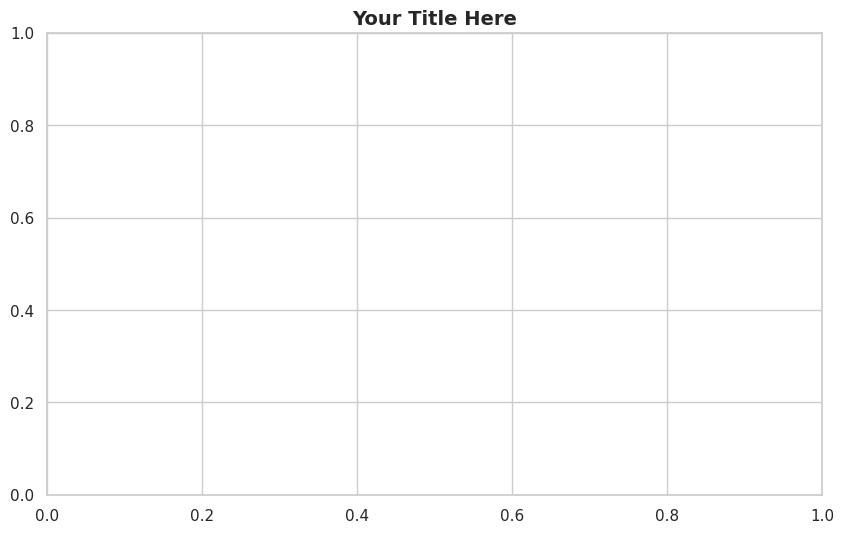

In [ ]:
# Set Seaborn style for better-looking plots
sns.set_theme(style="whitegrid")
sns.set_palette("husl")

# TODO: Create at least ONE meaningful visualization

# Example 1: Sentiment distribution
plt.figure(figsize=(10, 6))

# YOUR VISUALIZATION CODE HERE
# Hints for different chart types:

# For sentiment counts:
# sns.countplot(data=df, x='sentiment', palette='coolwarm')

# For word count distribution:
# sns.histplot(data=df, x='word_count', bins=20, kde=True)

# For sentiment scores:
# sns.boxplot(data=df, x='sentiment', y='sentiment_score')

plt.title('Your Title Here', fontsize=14, fontweight='bold')
plt.show()

In [ ]:
# TODO: Create a second visualization

# Ideas for advanced visualizations:

# 1. Top entities as horizontal bar chart:
# top_companies = pd.Series(all_companies).value_counts().head(10)
# plt.figure(figsize=(10, 6))
# sns.barplot(x=top_companies.values, y=top_companies.index, palette='viridis')

# 2. Sentiment by word count:
# sns.scatterplot(data=df, x='word_count', y='sentiment_score', hue='sentiment')

# 3. Combined plot with subplots:
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# sns.countplot(data=df, x='sentiment', ax=axes[0])
# sns.histplot(data=df, x='word_count', ax=axes[1])

# YOUR CODE HERE

In [ ]:
# Optional: Create a professional multi-panel figure
# This is more advanced but looks impressive in presentations!

# fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# fig.suptitle(f'{YOUR_SITE_NAME} News Analysis', fontsize=16, fontweight='bold')

# TODO: Add 4 different visualizations
# Each subplot: axes[row, col]

# YOUR CODE HERE (if you have time)


## Step 6: Find Your Insights

### Think about:
- What's the overall mood of today's news?
- Which companies/people are making headlines?
- Are there any surprising patterns?
- How does this compare to what you expected?

In [ ]:
# TODO: Calculate and display your key findings

print("="*50)
print(f"📰 {YOUR_SITE_NAME} ANALYSIS RESULTS")
print("="*50)
print(f"Time: {datetime.now().strftime('%H:%M')}")
print()

# TODO: Fill in your findings
print("📊 KEY METRICS:")
print(f"• Total articles analyzed: ???")
print(f"• Positive sentiment rate: ???%")
print(f"• Average headline length: ??? words")
print()

print("🏆 TOP DISCOVERIES:")
print(f"• Most mentioned company: ???")
print(f"• Most mentioned person: ???")
print(f"• Surprising finding: ???")
print()

print("💡 OUR MAIN INSIGHT:")
print("???")
print("="*50)

📰 BBC Tech ANALYSIS RESULTS
Time: 12:00

📊 KEY METRICS:
• Total articles analyzed: ???
• Positive sentiment rate: ???%
• Average headline length: ??? words

🏆 TOP DISCOVERIES:
• Most mentioned company: ???
• Most mentioned person: ???
• Surprising finding: ???

💡 OUR MAIN INSIGHT:
???


## Step 7: Prepare Your Presentation

Use this template to structure your 2-3 minute presentation.

### Your 2-3 minute presentation should cover:

1. **Data Collection (30 sec)**
   - Which site you analyzed
   - How many articles you got
   - Main challenge you faced

2. **AI Analysis (30 sec)**
   - Overall sentiment findings
   - Key entities discovered

3. **Key Insight (30 sec)**
   - Your most interesting finding
   - Why it matters

4. **Show Your Best Visualization (30 sec)**
   - Explain what it shows
   - What it reveals about today's news

---

## 🆘 Quick Reference

### BeautifulSoup
```python
soup.find_all('tag', class_='classname')
soup.select('css-selector')
element.get_text()
element.get('attribute')
```

### Regex Patterns
```python
re.sub(r'\d+', '', text)  # Remove numbers
re.sub(r'http\S+', '', text)  # Remove URLs
re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only letters
```

### Transformers
```python
result = sentiment_analyzer("text")
# Returns: [{'label': 'POSITIVE', 'score': 0.99}]

entities = ner_pipeline("text")
# Returns: [{'word': 'Apple', 'entity_group': 'ORG', ...}]
```

### Pandas
```python
df['column'].value_counts()
df['column'].apply(function)
df.groupby('column').mean()
```

### Seaborn Visualizations
```python
# Set theme
sns.set_theme(style="whitegrid")
sns.set_palette("husl")  # or 'coolwarm', 'viridis', 'muted'

# Common plots
sns.countplot(data=df, x='column')  # Count categories
sns.histplot(data=df, x='column', bins=20, kde=True)  # Distribution
sns.barplot(x=values, y=labels, palette='viridis')  # Bar chart
sns.boxplot(data=df, x='category', y='values')  # Box plot
sns.scatterplot(data=df, x='col1', y='col2', hue='category')  # Scatter

# Multi-panel figures
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.countplot(data=df, x='sentiment', ax=axes[0,0])
```



## 🏁 Final Checklist

Before presenting, make sure you have:

- [ ] Successfully scraped 5-10 headlines
- [ ] Cleaned and processed the text data
- [ ] Applied at least 2 AI models (sentiment + NER)
- [ ] Created at least 1 meaningful visualization
- [ ] Identified 3 key insights or findings
- [ ] Prepared your 2-3 minute presentation
- [ ] Saved your work!

## 💡 Tips for Success

1. **Start Simple**: Get 5 headlines working before trying for 50
2. **Test Often**: Print results after each step
3. **Collaborate**: Assign clear roles to team members
4. **Focus on Insights**: Quality over quantity
5. **Time Management**: Leave 10 minutes for presentation prep

## 🎉 Good luck and have fun analyzing the news!